In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import modutils
import pickle
import time, datetime
import sklearn, sklearn.metrics, sklearn.decomposition
import collections
import matplotlib.pyplot as plt
import seaborn

train_file = '../DataSets/Toxic/dev_train.csv'
test_file = '../DataSets/Toxic/dev_valid.csv'

In [8]:
src_train = pd.read_csv(train_file)
src_test = pd.read_csv(test_file)

lens = np.array([len(x) for x in src_train.comment_text])
print(np.percentile(lens, q=[50, 75, 90, 95, 99]))

chars = sorted(dict(collections.Counter([z for x in src_train.comment_text for z in x])).items(),
               key=lambda x:x[1], reverse=True)
chars_pct = np.cumsum([x[1] for x in chars]) / np.sum([x[1] for x in chars])
chars_res = list(zip([x[0] for x in chars], chars_pct))

src_train.head()

[  205.   435.   891.  1369.  3474.]


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
2,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
3,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
4,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0


In [3]:
def build_charcnnl1_graph(input_shape, cnn_arch, fc_arch, reg=0.1):
    tf.reset_default_graph()

    with tf.name_scope('Input'):
        tf_in_x = tf.placeholder(tf.int32, shape=(None, input_shape[0]))
        tf_in_y = tf.placeholder(tf.int32, shape=(None,))
        tf_in_cnn_keep = tf.placeholder_with_default(0.0, shape=(), name='Dropout-CNN')
        tf_in_cnn_input_keep = tf.placeholder_with_default(0.0, shape=(), name='Dropout-Input')
        tf_in_fc_keep = tf.placeholder_with_default(0.0, shape=(), name='Dropout-FC')
        tf_in_fc_final_keep = tf.placeholder_with_default(0.0, shape=(), name='Dropout-Final')
        tf_in_training = tf.placeholder_with_default(False, shape=(), name='Training')

        tf_x1hot = tf.one_hot(tf_in_x, input_shape[1])
        tf_temp = tf_x1hot
        
    tf_conv1kernel = None

    for (i, (conv_filters, conv_width, conv_stride, pool_width, pool_stride)) in enumerate(cnn_arch):
        with tf.name_scope('Conv-MaxPool-{:02d}'.format(i)):
            if i > 0:
                tf_temp = tf.layers.dropout(tf_temp, rate=tf_in_cnn_keep, training=tf_in_training)
            else:
                tf_temp = tf.layers.dropout(tf_temp, rate=tf_in_cnn_input_keep, training=tf_in_training)
            tf_temp = tf.layers.conv1d(tf_temp, conv_filters, conv_width, conv_stride, activation=tf.nn.relu)
            if i == 0:
                tf_conv1kernel = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'conv1d')[0]
            tf_temp = tf.layers.max_pooling1d(tf_temp, pool_width, pool_stride)

    with tf.name_scope('FC'):
        tf_temp = tf.contrib.layers.flatten(tf_temp)
        for sz in fc_arch:
            tf_temp = tf.layers.dropout(tf_temp, rate=tf_in_fc_keep, training=tf_in_training)
            tf_temp = tf.layers.dense(tf_temp, sz, activation=tf.nn.elu)
            
        tf_temp = tf.layers.dropout(tf_temp, rate=tf_in_fc_final_keep, training=tf_in_training)
        tf_final = tf.layers.dense(tf_temp, 2)
        tf_prob = tf.nn.softmax(tf_final)
        tf_predicted = tf.cast(tf.argmax(tf_prob, axis=1), dtype=tf.int32)

    with tf.name_scope('LOSS'):
        tf_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf_in_y, logits=tf_final))
        tf_l1loss = tf.reduce_mean(tf.abs(tf_conv1kernel))
        tf_finloss = tf_loss + tf_l1loss * reg
        tf_train = tf.train.AdamOptimizer(1e-3).minimize(tf_finloss)
        
        tf_rocauc, tf_upd_rocuac = tf.metrics.auc(labels=tf_in_y, predictions=tf_prob[:,1], num_thresholds=10000)
        tf_gini = tf_rocauc * 2 - 1
        tf_accuracy, tf_upd_accuracy = tf.metrics.accuracy(labels=tf_in_y, predictions=tf_predicted)
        tf_update_metrics = tf.group(tf_upd_rocuac, tf_upd_accuracy)
        
        tfsummary_logloss = tf.summary.scalar('Log-Loss', tf_loss)
        tfsummary_gini = tf.summary.scalar('1-Gini', 1-tf_gini)
        tfsummary_accuracy = tf.summary.scalar('1-Accuracy', 1-tf_accuracy)
        tfsummary = tf.summary.merge([tfsummary_logloss, tfsummary_gini, tfsummary_accuracy])

    return {'in':{'data':tf_in_x, 'label':tf_in_y, 'keep-cnn':tf_in_cnn_keep, 'keep-fc':tf_in_fc_keep,
                  'keep-final': tf_in_fc_final_keep, 'dropout': tf_in_training},
            'out':{'logit':tf_final, 'prob':tf_prob},
            'run':{'loss': tf_loss, 'upd_metrics':tf_update_metrics,
                   'gini':tf_gini, 'accuracy':tf_accuracy,
                   'train': tf_train, 'summary':tfsummary}}

In [65]:
tf.reset_default_graph()
build_charcnnl1_graph((100, 61), [(80, 5, 1, 20, 20)], [])
tfsSaver = tf.train.Saver(max_to_keep=5)

with tf.Session() as tfs:
    tfsSaver.restore(tfs, '../Models/24Toxic05CCNNL1_v0/model-02.ckpt')
    conv_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'conv1d')
    conv1kernel = tfs.run(conv_vars[0])
    conv1bias = tfs.run(conv_vars[1])

INFO:tensorflow:Restoring parameters from ../Models/24Toxic05CCNNL1_v0/model-02.ckpt


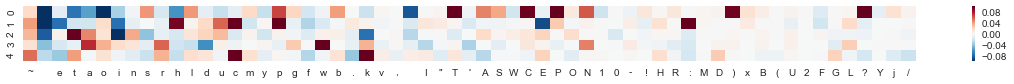

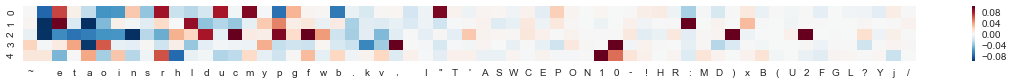

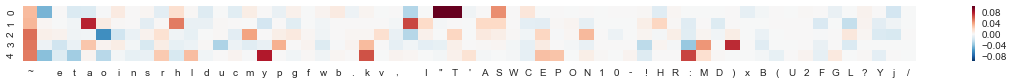

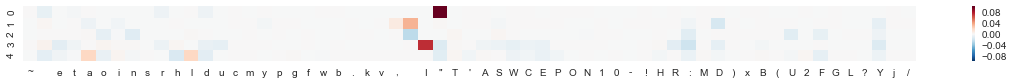

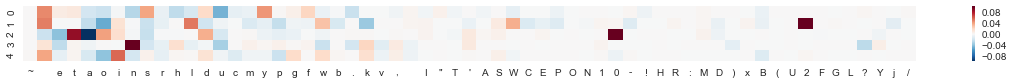

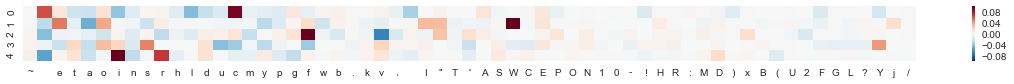

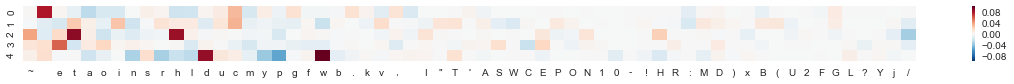

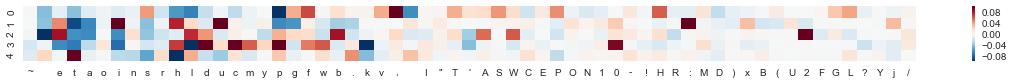

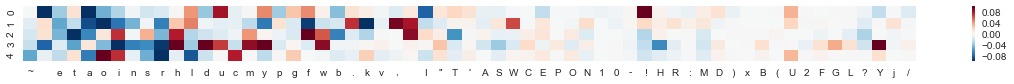

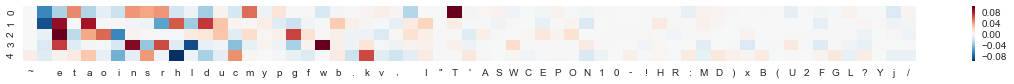

In [66]:
vrange=0.1
for i in range(10):
    plt.figure(figsize=(20,1))
    seaborn.heatmap(conv1kernel[:,:,i], xticklabels=(['~'] + [x[0] for x in chars_res[:60]]), vmin=-vrange, vmax=vrange)
    plt.show()

In [67]:
c1kr = conv1kernel.reshape(-1, 80)

In [68]:
c1kr_cov = np.matmul(c1kr.transpose(), c1kr)

In [69]:
c1kr_std = np.sqrt(np.diag(c1kr_cov))

In [70]:
c1kr_cor = c1kr_cov / c1kr_std.reshape(-1,1) / c1kr_std.reshape(1, -1)

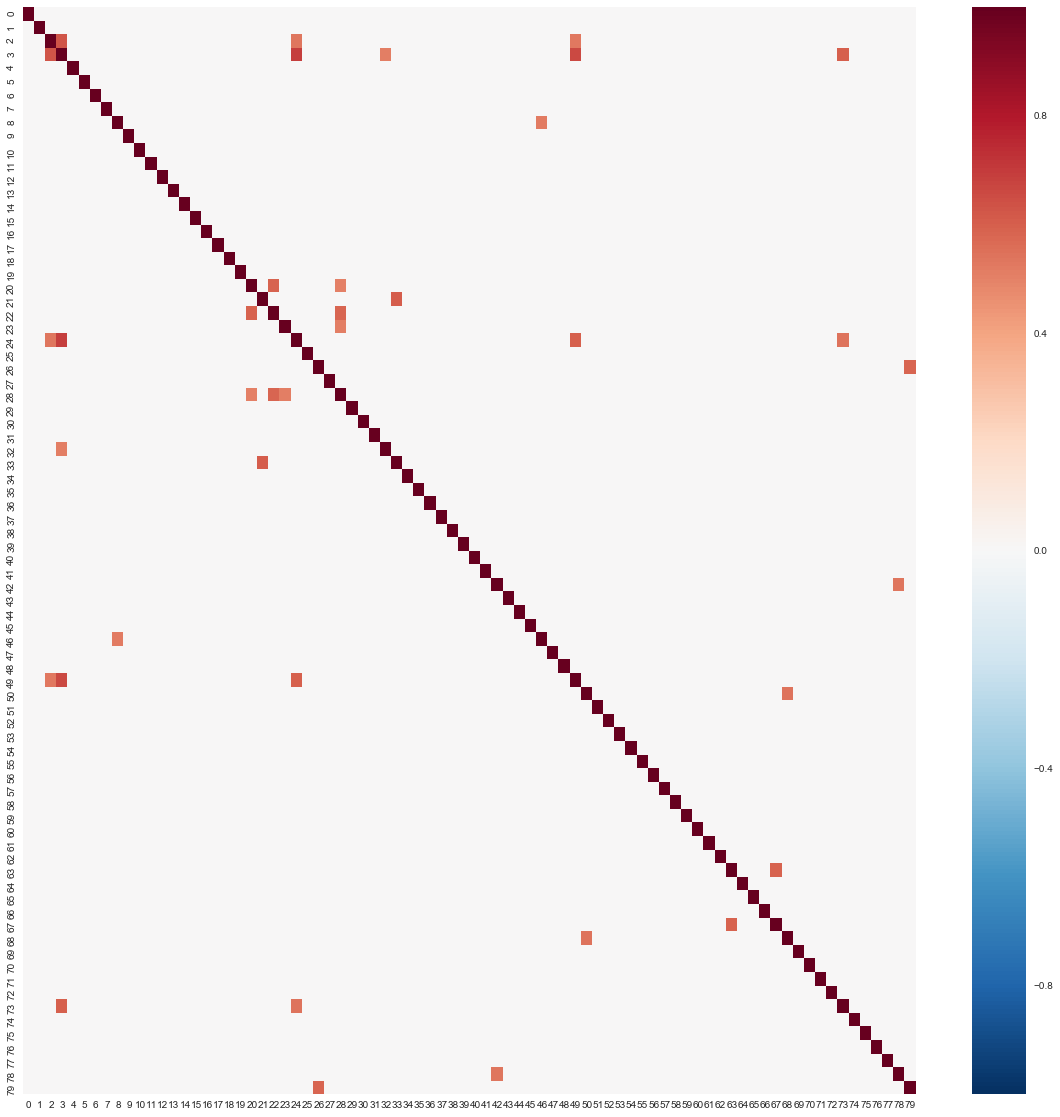

In [80]:
plt.figure(figsize=(20,20))
seaborn.heatmap(c1kr_cor * (c1kr_cor>0.5), vmin=-1, vmax=1)
plt.show()